In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import country_script
import education_script
import health_script
import population_script
import quality_of_life_script

# Data Summarization

In [2]:
country_df = country_script.getCountryList(True)
fact_table_df = pd.read_csv("./output/fact_table.csv")
year_df = pd.read_csv("./output/year.csv")

In [3]:
countries = ["Canada", "United States", "United Kingdom", "France", "Germany", "Sweden", "Australia", "Denmark", "Belgium"]

In [4]:
main_df = pd.merge(country_df, fact_table_df, on='CountryKey' )
main_df = pd.merge(main_df, year_df, on='YearKey')
# print(main_df.columns)
# print(main_df[["Year", "GDP", "Name"]][main_df["Name"] =="Canada"])

In [5]:
main_df["GDP"] = pd.to_numeric(main_df["GDP"])


In [6]:
gdp_df = main_df.pivot(index="Year", columns="Name", values="GDP")

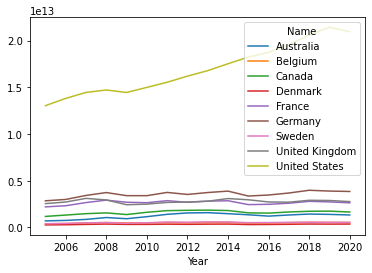

In [7]:
gdp_df.plot()
plt.show()

# Data Preprocessing
Want to create a model to predict a country's human development index based on attribute values from their health, population, quality of life, and education statistics.

In [8]:
final_df = pd.read_csv("./output/fact_table.csv")

In [ ]:
# columns with empty values
# education dimension
# literacy rate, adult male, female, total
# school enrollment primary, secondary, teritary
# public spending on education, total
# Pisa science, reading, mathmatics
# gender parity

# health dimension
# domestic government health expenditure
# hospital beds 
# immunization HEPB3, DPT, measles, pol3
# stillbirth rate
# nurses and midwives, physicians
# diabetes prevalence
# prevalence of HIV, tobacco use
# total alcohol consumption per capita
# mortality rate, male and female

# population dimension
# life expectancy at birth: female, male, total
# net migration

# quality of life dimension
# people with basic handashing 
# pregnant women receiving prenatla care
# births attended by skilled health staff
# community health workers
# consumption of iodized salt


In [9]:
# Country
# wil use - TotalPopulation, Birthrate, Size, GDP, Population Density
# all those columns are full
country_df = country_script.getCountryList(True)
country_df = country_df[["CountryKey", "Name", "TotalPopulation", "Birthrate", "Size", "GDP", "PopulationDensity"]]
final_df = pd.merge(final_df, country_df, left_on="CountryKey", right_on="CountryKey")

In [10]:
# Education
curent_df = education_script.getEducationList()
# will drop the 3 empty literacy rate columns
curent_df = curent_df.drop(["Literacy rate, adult female (% of females ages 15 and above)",
        "Literacy rate, adult male (% of males ages 15 and above)",
       "Literacy rate, adult total (% of people ages 15 and above)"], axis=1)
# setting the wanted columns
wanted_col_names = ['School enrollment, primary (% gross)',
       'School enrollment, secondary (% gross)',
       'School enrollment, tertiary (% gross)',
       'Public spending on education, total (% of GDP)',
       'PISA: Mean performance on the science scale',
       'PISA: Mean performance on the reading scale',
       'PISA: Mean performance on the mathematics scale',
       'Adjusted net enrolment rate, one year before the official primary entry age, adjusted gender parity index (GPIA)']
for current_col_name in wanted_col_names:
        curent_df[current_col_name] = pd.to_numeric(curent_df[current_col_name])
        for country in countries:
                current_col = curent_df[curent_df["Country Name"] == country][[current_col_name]]
                mean = np.mean(current_col)
                current_col = current_col.fillna(mean)
                for i in current_col.index:
                        curent_df.at[i, current_col_name] = current_col.at[i, current_col_name]

curent_df = curent_df[wanted_col_names]
#education_df.to_csv("temp.csv")
final_df = pd.merge(final_df, curent_df, left_on="EducationKey", right_index=True)

In [11]:
# Health
curent_df = health_script.getHealthList()
#print(health_df.columns)
# drop empty diabetes prevalence column
curent_df = curent_df.drop(['Diabetes prevalence (% of population ages 20 to 79)'], axis=1)
wanted_col_names = [
       'Domestic general government health expenditure (% of GDP)',
       'Hospital beds (per 1,000 people)',
       'Immunization, HepB3 (% of one-year-old children)',
       'Immunization, DPT (% of children ages 12-23 months)',
       'Immunization, measles (% of children ages 12-23 months)',
       'Immunization, Pol3 (% of one-year-old children)',
       'Mortality rate, infant (per 1,000 live births)',
       'Stillbirth rate (per 1,000 total births)',
       'Nurses and midwives (per 1,000 people)',
       'Physicians (per 1,000 people)',
       'Prevalence of HIV, total (% of population ages 15-49)',
       'Prevalence of current tobacco use (% of adults)',
       'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
       'Mortality rate, adult, male (per 1,000 male adults)',
       'Mortality rate, adult, female (per 1,000 female adults)']

for current_col_name in wanted_col_names:
        curent_df[current_col_name] = pd.to_numeric(curent_df[current_col_name])
        for country in countries:
                current_col = curent_df[curent_df["Country Name"] == country][[current_col_name]]
                mean = np.mean(current_col)
                current_col = current_col.fillna(mean)
                for i in current_col.index:
                        curent_df.at[i, current_col_name] = current_col.at[i, current_col_name]
curent_df = curent_df[wanted_col_names]
#curent_df.to_csv("temp.csv")
final_df = pd.merge(final_df, curent_df, left_on="HealthKey", right_index=True)
# will use - domesic general government health expenditure 

# Hospital beds

# immunization, HepB3

# immunization DPT

# immuzation measles

# immunization pol3

# mortality rate, infant

# stillbirth rate 

# nurses and midwives

# physicians

# drop diabetes prevalence - no data

# prevalence of HIV - lots of missing data

# prevalence of current tobacco - lots of missing data

# total alcohol consumption per capita 

# mortality rate male

# mortality rate female



In [12]:
# Population
curent_df = population_script.getPopulationList()
# drop net migration
curent_df = curent_df.drop(['Net migration'], axis=1)
wanted_col_names = ['Life expectancy at birth, female (years)',
       'Life expectancy at birth, male (years)',
       'Life expectancy at birth, total (years)',
       'Population growth (annual %)',
       'Labor force, female (% of total labor force)', 'Labor force, total',
       'Rural population growth (annual %)',
       'Urban population growth (annual %)',
       'Rural population (% of total population)',
       'Urban population (% of total population)']

for current_col_name in wanted_col_names:
        curent_df[current_col_name] = pd.to_numeric(curent_df[current_col_name])
        for country in countries:
                current_col = curent_df[curent_df["Country Name"] == country][[current_col_name]]
                mean = np.mean(current_col)
                current_col = current_col.fillna(mean)
                for i in current_col.index:
                        curent_df.at[i, current_col_name] = current_col.at[i, current_col_name]

curent_df = curent_df[wanted_col_names]
#curent_df.to_csv("temp.csv")
final_df = pd.merge(final_df, curent_df, left_on="PopulationKey", right_index=True)
# life expectancy at birth female

# life expectancy at birth male

# life expectancy at birth total

# net migration - might drop, little data

# population growth 

# labor force female

# labor force total

# rural population growth

# urban population grwoth

# rural population 

# urban population

In [13]:
# Quality of life
curent_df = quality_of_life_script.getQualityOfLifeList()
# drop empty columns
curent_df = curent_df.drop(['People with basic handwashing facilities including soap and water (% of population)',
                            'Pregnant women receiving prenatal care (%)',
                            'Community health workers (per 1,000 people)',
                            'Consumption of iodized salt (% of households)'
                            ], axis=1)
wanted_col_names = ['People using at least basic drinking water services (% of population)',
       'People using at least basic sanitation services (% of population)',
       'Unemployment, female (% of female labor force)',
       'Unemployment, male (% of male labor force)',
       'Unemployment, total (% of total labor force)',
       'Age dependency ratio (% of working-age population)',
       'Births attended by skilled health staff (% of total)']

for current_col_name in wanted_col_names:
        curent_df[current_col_name] = pd.to_numeric(curent_df[current_col_name])
        for country in countries:
                current_col = curent_df[curent_df["Country Name"] == country][[current_col_name]]
                mean = np.mean(current_col)
                current_col = current_col.fillna(mean)
                for i in current_col.index:
                        curent_df.at[i, current_col_name] = current_col.at[i, current_col_name]

curent_df = curent_df[wanted_col_names]
#curent_df.to_csv("temp.csv")
final_df = pd.merge(final_df, curent_df, left_on="QualityOfLifeKey", right_index=True)
# people using at least basic drinking water services

# people using at least basic sanitation services

# people with basic handwashing facilities including soap - drop, no data

# unemployment female

# unemployment male

# unemployment total

# pregnant women receiving prenatal care - drop, no data

# age dependency ratio 

# births attended by skilled health staff - little data

# community health workers - drop, no data

# consumption of iodized salt - drop, no data

In [14]:
final_df.to_csv("final.csv")
print(final_df.columns)


Index(['YearKey', 'CountryKey', 'EducationKey', 'QualityOfLifeKey',
       'HealthKey', 'PopulationKey', 'QualityOfLife', 'DevelopmentIndex',
       'HumanDevelopmentIndex', 'Name', 'TotalPopulation', 'Birthrate', 'Size',
       'GDP', 'PopulationDensity', 'School enrollment, primary (% gross)',
       'School enrollment, secondary (% gross)',
       'School enrollment, tertiary (% gross)',
       'Public spending on education, total (% of GDP)',
       'PISA: Mean performance on the science scale',
       'PISA: Mean performance on the reading scale',
       'PISA: Mean performance on the mathematics scale',
       'Adjusted net enrolment rate, one year before the official primary entry age, adjusted gender parity index (GPIA)',
       'Domestic general government health expenditure (% of GDP)',
       'Hospital beds (per 1,000 people)',
       'Immunization, HepB3 (% of one-year-old children)',
       'Immunization, DPT (% of children ages 12-23 months)',
       'Immunization, measle

In [ ]:
# columns to scale
columns_to_scale = [
       'TotalPopulation', 'Birthrate', 'Size', 'GDP', 'PopulationDensity',
       'School enrollment, primary (% gross)',
       'School enrollment, secondary (% gross)',
       'School enrollment, tertiary (% gross)',
       'Public spending on education, total (% of GDP)',
       'PISA: Mean performance on the science scale',
       'PISA: Mean performance on the reading scale',
       'PISA: Mean performance on the mathematics scale',
       'Adjusted net enrolment rate, one year before the official primary entry age, adjusted gender parity index (GPIA)',
       'Domestic general government health expenditure (% of GDP)',
       'Hospital beds (per 1,000 people)',
       'Immunization, HepB3 (% of one-year-old children)',
       'Immunization, DPT (% of children ages 12-23 months)',
       'Immunization, measles (% of children ages 12-23 months)',
       'Immunization, Pol3 (% of one-year-old children)',
       'Mortality rate, infant (per 1,000 live births)',
       'Stillbirth rate (per 1,000 total births)',
       'Nurses and midwives (per 1,000 people)',
       'Physicians (per 1,000 people)',
       'Prevalence of HIV, total (% of population ages 15-49)',
       'Prevalence of current tobacco use (% of adults)',
       'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
       'Mortality rate, adult, male (per 1,000 male adults)',
       'Mortality rate, adult, female (per 1,000 female adults)',
       'Life expectancy at birth, female (years)',
       'Life expectancy at birth, male (years)',
       'Life expectancy at birth, total (years)',
       'Population growth (annual %)',
       'Labor force, female (% of total labor force)', 'Labor force, total',
       'Rural population growth (annual %)',
       'Urban population growth (annual %)',
       'Rural population (% of total population)',
       'Urban population (% of total population)',
       'People using at least basic drinking water services (% of population)',
       'People using at least basic sanitation services (% of population)',
       'Unemployment, female (% of female labor force)',
       'Unemployment, male (% of male labor force)',
       'Unemployment, total (% of total labor force)',
       'Age dependency ratio (% of working-age population)',
       'Births attended by skilled health staff (% of total)']
scaler = StandardScaler()
final_df[columns_to_scale] = scaler.fit_transform(final_df[columns_to_scale])
final_df.to_csv("final.csv")
